In [ ]:
# Run in Colab to install local packages
                                             # Package Websites
!pip install spacy                           # https://spacy.io/
!pip install transformers sentencepiece      # https://huggingface.co/transformers
!pip install datasets                        # https://huggingface.co/docs/datasets
!pip install scikit-learn                    # https://scikit-learn.org
!pip install pandas                          # https://pandas.pydata.org/

!python -m spacy download en_core_web_sm     # Install English processing pipelines

# A brief introduction to NLP with spaCy, Scikit-Learn and 🤗 Transformers

**Gabriele Sarti**, PhD Student in NLP at the University of Groningen

[Website](https://gsarti.com/) | [Github](https://github.com/gsarti) | [Publications](https://scholar.google.com/citations?user=sK0B_08AAAAJ)

In many real-world applications, text is just one of the multiple sources of information that can be user for inference. In this tutorial, we will reproduce a standard machine learning pipeline integrating text and non-textual information.

Importantly, we will start from the basics to establish some baseline results using the popular [Scikit-learn](https://scikit-learn.org/stable/index.html) library. 

While these represents a small but comprehensive set of steps to train models on textual (and non-textual) information, nowadays NLP practitioners operate mainly with pre-trained word embeddings for representing texts. 

In the final part of this tutorial, we will a brief overview of the powerful [🤗 transformers](https://github.com/huggingface/transformers) librar and more advanced use cases such as natural language generation.

# A Simple Wine Scoring Pipeline 🍷

For our exercise, will use a filtered version of the Kaggle's [Winemag dataset](https://www.kaggle.com/zynicide/wine-reviews) containing a collection of wine reviews (`description`), accompanied by some metadata: `country` and `provice` of provenance, `variety` of wine, `price` per bottle and the WineEnthusiast rating (`points`) describing the wine quality.

*Our final goal is to build and evaluate a simple linear regression model that predicts the `points` assigned to a wine given its `description` and its other features.* This is commonly know as a **regression problem**, since you are trying to predict a continuous quantity, as opposed to a discrete one (e.g. a class label).

Most importantly, the general procedure and methods you will use can be apply to any kind of data with the adequate preprocessing, and can be extended to other tasks such as binary and multiclass classification.

We can have a look at the data, which has been conveniently packed by us into a 🤗 Dataset object:

In [ ]:
from datasets import load_dataset

# Hosted on the HF Hub here: https://huggingface.co/datasets/GroNLP/ik-nlp-22_winemag 
data = load_dataset("GroNLP/ik-nlp-22_winemag", split="train[:10000]")
print(data)
df = data.to_pandas()
df.head()

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/GroNLP___csv/GroNLP--ik-nlp-22_winemag-a49fc23fe3d26a73/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.
Dataset({
    features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
    num_rows: 10000
})


,index,country,description,points,price,province,variety
0,129857,US,Dusty tannins make for a soft texture in this ...,90,44.0,California,Merlot
1,112217,US,Sweet-tart Maraschino cherry and bitter brambl...,85,14.0,New York,Pinot Noir
2,114216,France,A lightly orange-colored rosé that is made by ...,92,90.0,Champagne,Champagne Blend
3,37808,France,"A ripe wine that is almost off dry, this has a...",85,17.0,Bordeaux,Bordeaux-style Red Blend
4,31157,US,"Crisp and very floral, this is a beautiful sho...",92,20.0,California,Pinot Gris


### Text Preprocessing

Text is messy. The goal of preprocessing is to reduce the amount of noise (= unnecessary variation), while maintaining the signal. There is no one-size-fits-all solution, but preserving only content words can be a good heuristic in this context. We can also reduce the size of the vocabulary by means of a **lemmatizer**.

In the following code, we extract lemmas and POS tags using spaCy, and then use `.map` to apply a function to our `Dataset`.

In [ ]:
import spacy

# Disable unused components
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def clean_text(text):
    '''Reduce text to lower-case lemmatized content words.'''
    content_op = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN']
    lemmas = [
        token.lemma_ for token in nlp(text) 
        if token.pos_ in content_op
    ]
    return ' '.join(lemmas)

clean_text('This is a test sentence. And here comes another one... Go me!')

'test sentence here come one go'

Let's now apply this cleaning function to the `description` column of the dataset:

In [ ]:
df['clean_text'] = df['description'].apply(clean_text)
df[['description', 'clean_text']].head()

,description,clean_text
0,Dusty tannins make for a soft texture in this ...,dusty tannin make soft texture wine subtle dry...
1,Sweet-tart Maraschino cherry and bitter brambl...,sweet tart maraschino cherry bitter bramble no...
2,A lightly orange-colored rosé that is made by ...,lightly orange colored rosé make macerate grap...
3,"A ripe wine that is almost off dry, this has a...",ripe wine almost off dry ripe cherry character...
4,"Crisp and very floral, this is a beautiful sho...",Crisp very floral beautiful showcase Anderson ...


### Representing Text

Now that we have a more compact representation of the text, the next step is converting it into a vector representation. For this purpose, we will use the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class provided by Scikit-learn. This class converts a collection of text documents to a matrix of [TF-IDF scores](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) reflecting the importance of a word in a document, and in relation to the full corpus.

**Term frequency**, $tf(t,d)$, is the relative frequency of term $t$ within document $d$, with $f_{t,d}$ being the count of occurrences of $t$ in $d$:

$$\text{tf}(t,d) = \frac{f_{t,d}}{\sum_{t'\in d} f_{t',d}}$$

**Inverse document frequency** is a measure of how much information the word provides, i.e., if it is common or rare across documents collection $D$. It is the logarithmically scaled inverse fraction of the documents that contain the word:

$$\text{idf}(t,D) = \log \frac{|D|}{|\{d \in D: t \in d\}|}$$

The resulting TF-IDF is obtained as:

$$\text{tf-idf}(t,d, D) = \text{tf}(t,d) \cdot \text{idf}(t,D)$$

A high weight in tf–idf is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents; the weights hence tend to filter out common terms. 

We are going to set some parameters to ensure a limited size of the vocabulary, but you can experiment with other values.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2), # Use 1-grams and 2-grams.
    min_df=0.001,      # Ignore terms that appear in less than 0.1% of the documents.
    max_df=0.75,       # Ignore terms that appear in more than 75% of documents.
    max_features=50,  # Use only the top 1000 most frequent words.
    stop_words='english'
)

X = vectorizer.fit_transform(df['clean_text'])

Each column correspond to one of the top 1000 words

In [ ]:
vectorizer.vocabulary_['acidity'] # vectorizer.get_feature_names()[0] to retrieve "bitter"

0

In [ ]:
## Converting the sparse text vectors to a pandas dataframe
## Every column is a word, e.g. w_wine, w_glass, etc.
text_vectors = pd.DataFrame(
    X.toarray(),
    columns=["w_" + w for w in vectorizer.get_feature_names()]
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
text_vectors

,w_acidity,w_apple,w_aroma,w_balance,w_berry,w_black,w_black cherry,w_blackberry,w_blend,w_bodied,...,w_spice,w_sweet,w_tannin,w_texture,w_touch,w_vanilla,w_vineyard,w_white,w_wine,w_year
0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.323421,0.000000,0.273223,0.376893,0.000000,0.000000,0.000000,0.0,0.193834,0.000000
1,0.329238,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.460425,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.230131,0.000000
2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.365193,0.403801,0.000000,0.000000,0.0,0.187817,0.000000
3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.305468,0.000000,0.258056,0.355972,0.000000,0.000000,0.000000,0.0,0.183074,0.000000
4,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.400537,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.406332,0.449288,0.000000,0.000000,0.0,0.208974,0.000000
9996,0.000000,0.0,0.000000,0.398607,0.0,0.286872,0.0,0.0,0.000000,0.0,...,0.307185,0.000000,0.000000,0.357972,0.000000,0.000000,0.000000,0.0,0.368206,0.000000
9997,0.000000,0.0,0.000000,0.000000,0.0,0.227761,0.0,0.0,0.000000,0.0,...,0.243888,0.000000,0.206034,0.000000,0.000000,0.000000,0.306966,0.0,0.584671,0.000000
9998,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.318035,0.381348,0.268672,0.000000,0.000000,0.396751,0.000000,0.0,0.190606,0.000000


### Categorical -> One-Hot Conversion

Many of the available features in the datasets are categorical, and you will need to convert them to [one-hot vectors](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) in order to use them in a regression model. Luckily, the [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) class is readily available in Scikit-learn for this purpose. An even more convenient approach is to use the [`pandas.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function, which returns a pandas Dataframe with labeled one-hot encoded columns,

In [ ]:
import pandas as pd

country_vectors = pd.get_dummies(df["country"])
province_vectors = pd.get_dummies(df["province"])
variety_vectors = pd.get_dummies(df["variety"])
country_vectors

,Argentina,Australia,France,Germany,Italy,Portugal,Spain,US
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,1
9996,0,0,1,0,0,0,0,0
9997,0,0,1,0,0,0,0,0
9998,0,0,0,0,1,0,0,0


### Putting it all Together and Fitting a Model

Now that all the data is ready to be process, create two Pandas dataframes to train the model: `features` should be the concatenation of the `price` field plus all the vectorized features (`text_vectors`, `country_vectors`, `province_vectors`, `variety_vectors`), while `target` should be a single column of `points` field.

Finally, we will train a simple linear model using the `fit` method of an instance of the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model, which fits a regular least-squares linear regression to the features. A regression model is simply a function that takes a set of numeric values, called **features**, as input, and returns an output score. Fitting a model is the process of finding the right parameters, called **weights**, to map the input features to the output targets.

In [ ]:
features = pd.concat([text_vectors, country_vectors, province_vectors, variety_vectors], axis=1, ignore_index=True)
target = df["points"]

from sklearn.linear_model import LinearRegression

regressor = LinearRegression(n_jobs=-1)
regressor.fit(features, target)
print(regressor)

LinearRegression(n_jobs=-1)


### A Simple Baseline

Before evaluating the performances of your fitted model, you might want to establish a reasonable **baseline**, representing a null-hypothesis choice. In the case of regression, usually a simple statistical baseline is the mean of the targets, minimizing the prediction error in absence any information but the distribution of target values. The Scikit-learn library implements a [`DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) that can be used to fit various regression baselines, including the mean.

In [ ]:
from sklearn.dummy import DummyRegressor

baseline = DummyRegressor(strategy="mean")

baseline.fit(features, target)

DummyRegressor()

### Evaluation

Having a model is great, but how well does it do? Can it predict what it has seen? We need a way to estimate how well the model will work on new data. We will use two metrics: the [**mean absolute error**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (MAE), representing the mean positive prediction error across all tested instances, and the [**mean squared error**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE), where the prediction error is made positive by squaring its value rather than apply the $abs$ operator. The first gives a more intuitive sense of the model's performance, while the second is more robust to outliers, which are upweighted by the squaring operation.

Classifying new (held-out) data is called prediction. We reuse the weights we have learned before on a new data matrix to predict the new outcomes. 

**Important**: the new data needs to have the same number of features! This means using the same vectorizers you fitted on the training split, using only the `.transform` method on the test split.

In the following, we will use `test_features` and `test_target` to evaluate the model using the `.predict` method.

In [ ]:
# Load the test dataset
test = load_dataset("GroNLP/ik-nlp-22_winemag", split="test[:1000]").to_pandas()
test.head()

,index,country,description,points,price,province,variety
0,11602,US,"Pretty dark for a rosé, and heavy and rich, to...",83,18.0,California,Rosé
1,27260,US,"Attractive roasted, smoky aromas join ripe plu...",90,13.0,California,Merlot
2,76630,US,Vinified in stainless and left on the lees for...,90,14.0,Oregon,Pinot Gris
3,12014,US,"A beautiful Merlot, noble and classic. It does...",92,28.0,California,Merlot
4,9116,US,A palate-pleasing mix of juicy boysenberry fru...,90,35.0,Washington,Syrah


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reapply the same preprocessing to the test split of the dataset
test['clean_text'] = test['description'].apply(clean_text)
test_text_vectors = pd.DataFrame(vectorizer.transform(test['clean_text']).toarray())
test_country_vectors = pd.get_dummies(test["country"])
test_province_vectors = pd.get_dummies(test["province"])
test_variety_vectors = pd.get_dummies(test["variety"])
test_features = pd.concat([test_text_vectors, test_country_vectors, test_province_vectors, test_variety_vectors], axis=1, ignore_index=True)
test_target = test["points"]

# Use the regressor and the baseline to predict the test target
# using the predict method.
regressor_predictions = regressor.predict(test_features)
baseline_predictions = baseline.predict(test_features)

In [ ]:
# Print the scores
for metric in [mean_absolute_error, mean_squared_error]:
    print("Linear regressor", metric.__name__, metric(test_target, regressor_predictions))
    print("Mean baseline", metric.__name__, metric(test_target, baseline_predictions))
    print("---")

Linear regressor mean_absolute_error 2.161544921875
Mean baseline mean_absolute_error 2.6218500000000002
---
Linear regressor mean_squared_error 7.096795192718506
Mean baseline mean_squared_error 10.065019
---


### Minimal Visualization of Predictions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7facf440b250>]],
      dtype=object)

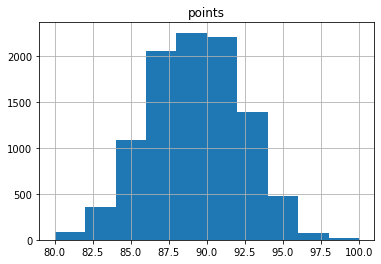

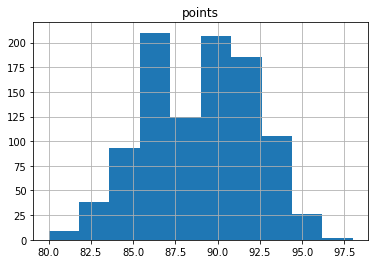

In [ ]:
# The variance of point scores is quite low both in training and testing
df.hist("points")
test.hist("points")

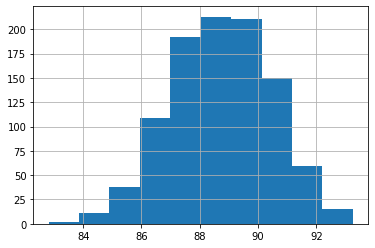

In [ ]:
# Regressor's predictions are very consistent with training distribution
pd.Series([x for x in regressor_predictions]).hist()

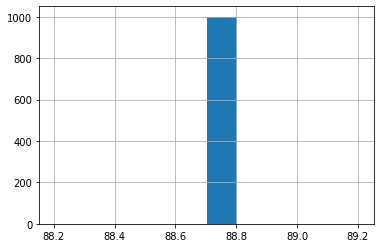

In [ ]:
pd.Series([x for x in baseline_predictions]).hist()

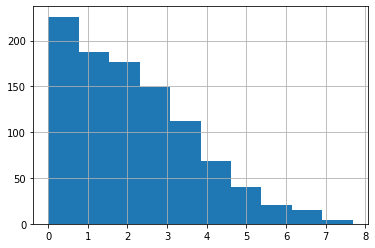

In [ ]:
# Most errors are < 1 point
pd.Series([abs(x - y) for x, y in zip(test_target, regressor_predictions)]).hist()

Recap:

1. Preprocess text to extract lemmatized content words.

2. Converting text to a vector representation using simple count-based approaches.

3. Convert categorical features into one-hot vectors.

4. Fit a simple model to predict the desired target.

5. Establish a simple baseline performance for the prediction task.

6. Evaluate the model performance on a held-out set.

# Advanced NLP with 🤗 Transformers

*This part of the tutorial is based off some chapters of the [HuggingFace Course](https://huggingface.co/course/chapter1/1), take a look for a more detailed overview!*

Transformer models are nowadays the state-of-the-art and de-facto standard to solve all kinds of NLP tasks, from tagging to machine translation, to text classification.

The usage of these models has been widely simplified and democratized by HuggingFace (🤗 in short), the startup behind the popular 🤗 Transformers library. The 🤗 Transformers library is completely open-source and provides a unified framework to create, train and use many transformer-based models, accompanied by a Cloud-hosting service called Model hub (similar to Pytorch and Tensorflow Hubs) in which every user can host and share pre-trained and fine-tuned open-source models.

In this section, we will briefly showcase the simple usage of pre-trained language models via `pipeline` objects

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
classifier("I've been waiting for this lecture to end for my whole life!")

[{'label': 'Negative', 'score': 0.4774186313152313}]

In [ ]:
translator = pipeline("text2text-generation", model="Helsinki-NLP/opus-mt-fr-en")

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/301M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/778k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
translator("Ce laboratoire a été adapté à partir du cours crée par HuggingFace.")

[{'generated_text': 'This laboratory was adapted from the course created by HuggingFace.'}]

In [ ]:
#qa_system = pipeline('question-answering', model="deepset/minilm-uncased-squad2")
qa_system({
    'question': 'Which percentage of the Amazon rainforest is found in Peru?',
    'context': """The Amazon rainforest (Portuguese: Floresta Amazônica or Amazônia;
Spanish: Selva Amazónica, Amazonía or usually Amazonia; French: Forêt amazonienne; Dutch: Amazoneregenwoud), also known in English as Amazonia or the Amazon Jungle,
is a moist broadleaf forest that covers most of the Amazon basin of South America. This basin encompasses 7,000,000 square kilometres (2,700,000 sq mi), of which 5,500,000
square kilometres (2,100,000 sq mi) are covered by the rainforest. This region includes territory belonging to nine nations. The majority of the forest is contained within
Brazil, with 60% of the rainforest, followed by Peru with 13%, Colombia with 10%, and with minor amounts in Venezuela, Ecuador, Bolivia, Guyana, Suriname and French Guiana.
States or departments in four nations contain "Amazonas" in their names. The Amazon represents over half of the planet's remaining rainforests, and comprises the largest and
most biodiverse tract of tropical rainforest in the world, with an estimated 390 billion individual trees divided into 16,000 species.
"""
})

{'score': 0.9277390837669373, 'start': 634, 'end': 637, 'answer': '13%'}

### Behind the Pipeline 🔍

![Behind the pipeline](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline-dark.svg)

### Building an Italian Visual Question Answering Pipeline

<div>
  <img src="https://i.etsystatic.com/10692502/r/il/0b3f65/1168985845/il_fullxfull.1168985845_2amd.jpg" alt="drawing" width="300"/>
  <img src="https://static.uglyhedgehog.com/upload/2022/4/11/t1-457624-ai_photo.jpg" alt="drawing" width="285"/>
</div>


In [ ]:
vqa = pipeline("vqa", model="dandelin/vilt-b32-finetuned-vqa")
it_to_en = pipeline("text2text-generation", model="Helsinki-NLP/opus-mt-it-en")
en_to_it = pipeline("text2text-generation", model="Helsinki-NLP/opus-mt-en-it")

Downloading:   0%|          | 0.00/136k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/470M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/814k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/343M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/789k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/814k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

In [ ]:
def ita_vqa(ita_question: str, image_url: str ) -> str:
  """ Returns the answer in Italian """
  eng_question = it_to_en(ita_question)[0]["generated_text"]
  eng_answer = vqa(image=image_url, question=eng_question)[0]["answer"]
  ita_answer = en_to_it(eng_answer)
  return ita_answer

dog_cushion = "https://i.etsystatic.com/10692502/r/il/0b3f65/1168985845/il_fullxfull.1168985845_2amd.jpg"
astronaut = "https://static.uglyhedgehog.com/upload/2022/4/11/t1-457624-ai_photo.jpg"

In [ ]:
ita_vqa("Cosa è raffigurato nell'immagine?", dog_cushion)

[{'generated_text': 'cane'}]

In [ ]:
ita_vqa("Di che colore è la sciarpa del cane?", dog_cushion)

[{'generated_text': 'rosso'}]

In [ ]:
ita_vqa("Di che colore è lo sfondo del disegno?", dog_cushion)

[{'generated_text': 'marrone'}]

In [ ]:
ita_vqa("Cosa è raffigurato nell'immagine?", astronaut)

[{'generated_text': 'cavallo'}]

In [ ]:
ita_vqa("Dove si trova il cavallo?", astronaut)

[{'generated_text': "all'esterno"}]

In [ ]:
ita_vqa("Di che colore è lo sfondo dell'immagine?", astronaut)

[{'generated_text': 'nero'}]